## Exploring the Association Between Gold and Indicators of a Recession 

One of the most accurate indicators of a recession is the yield curve. The yield curve is the difference in basis points between the yield of a 10-year treasury note and the yield of a 2-year treasury note. From the image below, we can see that every time the curve has gone negative, the U.S. has entered into a recession soon after. The spread between the 2- and 5-year yields has already gone negative, and it looks like the 2- and 10-year yields could follow.

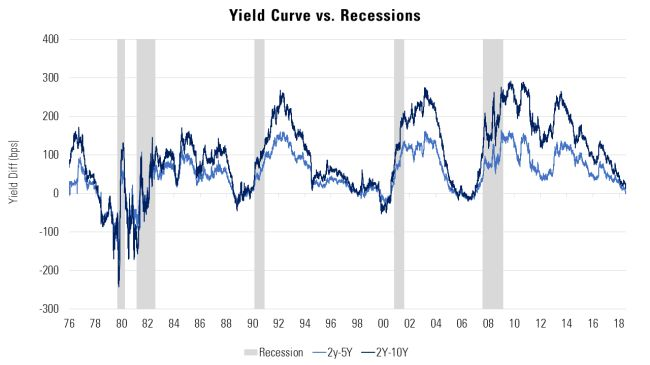

In [1]:
from IPython.display import Image

fig = Image(filename=('data/yield_curve.png'))
fig

The chart above is shown to confirm my suspision of an impending recession. The rest of the notebook will look at other indicators that could predict the price of gold.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from datetime import datetime
import pandas_datareader.data as web
import datetime as dt

Below, three csv files are read in to dataframes so that they can be cleaned and merged into one. Data includes:
* Price of gold 
* Consumer confidence index
* Federal funds rate

From this data, four new columns are created:
* Two-week moving average of gold(MA_14), and a one-week moving average of gold(MA_7). These two are used in conjunction to create a moving average crossover, which is commonly used as an indicator in algorithms. 
* A two-month moving average of the federal funds rate(MA_FFR).
* The derivative of the federal funds rate moving average(FFR_dy/dx). This will also be used as an indicator.

In [2]:
def preprocess_data():
   
    #fixed daily price of gold for the last 50 years
    #Source: ICE Benchmark Administration Limited (IBA), Gold Fixing Price 10:30 A.M. (London time) in London Bullion Market, based in U.S. Dollars [GOLDAMGBD228NLBM], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/GOLDAMGBD228NLBM, December 30, 2018.
    df_xau = pd.read_csv('data/GoldPrice.csv', index_col='DATE', parse_dates=True)
    #consumer confidence index
    #Source: Main Economic Indicators: Business tendency and consumer opinion surveys 
    df_cci = pd.read_csv('data/CCI.csv', index_col='TIME', parse_dates=True)
    #federal funds rate
    #Source: Board of Governors of the Federal Reserve System (US), Effective Federal Funds Rate [FEDFUNDS], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/FEDFUNDS, January 2, 2019
    df_ffr = pd.read_csv('data/FFR.csv', index_col='DATE', parse_dates=True)
    
    #clean data
    
    #clean XAU data
    df_xau['PRICE'].replace('.', 'NaN', inplace=True)
    df_xau['PRICE'] = df_xau[df_xau['PRICE'].apply(lambda x: x.isdecimal())]
    df_xau['PRICE'].fillna(method='ffill', inplace=True)
    df_xau['PRICE'] = df_xau['PRICE'].astype(int)
    
    #make values integers
    df_cci['Value'] = df_cci['Value'].astype(int)
    df_ffr['FEDFUNDS'] = df_ffr['FEDFUNDS'].astype(int)

    #merge dataframes with index that has values for all three columns (resample data to monthly)
    df = pd.merge(df_xau, df_cci['Value'].to_frame(), left_index=True, right_index=True, how='inner')
    df = df.merge(df_ffr['FEDFUNDS'].to_frame(), left_index=True, right_index =True, how='inner') 
    df.rename(index=str, columns={'PRICE' : 'XAU' , 'Value' : 'CCI', 'FEDFUNDS' : 'FFR'}, inplace=True)

    #fix formatting
    df.index = df.index.str.replace(' 00:00:00', '')
    df.index = pd.to_datetime(df.index, infer_datetime_format=True)
    df = df[~df.index.duplicated(keep='first')]
    df = df.groupby(level=0).first() 
    df.index.name = 'DATE'
    
    #create moving averages for gold
    df['MA14'] = df['XAU'].rolling(window=14).mean()
    df['MA7'] = df['XAU'].rolling(window=7).mean()
    
    #2 year moving average 
    df['MA_FFR'] = df['FFR'].rolling(window=12*2).mean()
    
    #derivative of moving average
    dy = df['MA_FFR'].diff()
    dx = df.index.to_series().diff().dt.total_seconds()/86400
    df['FFR_dy/dx'] = dy/dx
    
    
    #get recession data
    recessions = web.DataReader(['USREC'], 'fred', pd.to_datetime('1968-01-01'), pd.datetime.today())
    
    
    return df, recessions

In [29]:
df, recessions = preprocess_data()
print(df.tail())

             XAU  CCI  FFR         MA14          MA7    MA_FFR  FFR_dy/dx
DATE                                                                     
2018-05-01  1328  101    1  1274.857143  1300.857143  0.375000   0.000683
2018-06-01  1294  101    1  1276.785714  1306.857143  0.416667   0.001344
2018-08-01  1250  101    1  1278.071429  1302.857143  0.458333   0.000683
2018-10-01  1196  101    2  1277.071429  1290.857143  0.541667   0.001366
2018-11-01  1220  101    2  1276.285714  1282.285714  0.625000   0.002688


In [28]:
#export to csv so it can be imported into the algorithm file
df.to_csv('data/indicators.csv')

The function below can be used to graph two different lines on the same chart 

In [44]:
def graph_data(val1,val2): 
    style.use('ggplot')
    fig, ax1 = plt.subplots()
    ax1.plot(val1.index, val1)
    #ax1.plot(a.index, b)
    ax2 = ax1.twinx()
    ax2.plot(val2, c='g')
    ax1.set_xlabel('Year')
    ax1.set_ylabel(val1.name)
    ax2.set_ylabel(val2.name)
    ax1.legend(loc=0, fontsize=11, frameon=True).get_frame().set_edgecolor('blue')
    ax2.legend(loc=0, fontsize=11, frameon=True).get_frame().set_edgecolor('blue')
    
    #draw recession lines
    for i, val in enumerate(recessions.values):
        if recessions['USREC'][i]==1:
            ax1.axvspan(recessions.index[i], recessions.index[i], color='grey', alpha=0.35)

First, we can look at the association between the price of gold and the consumer confidence index

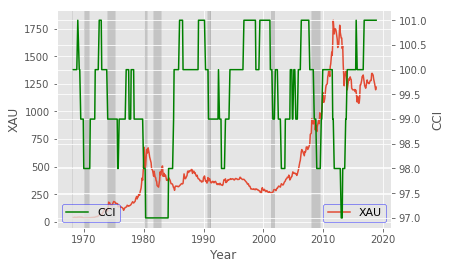

In [45]:
graph_data(df['XAU'], df['CCI'])

It looks like there is an association between the two, but only when the price of gold is more volatile. This is good for visualizing the interaction between the economy and the price of gold, but it doesn't look like it has much predictive power. This makes sense because the consumer confidence index tends to react to economic conditions, not cause them.

Next we can look at the price of gold and the federal funds rate.

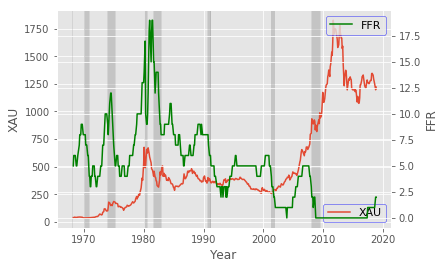

In [46]:
graph_data(df['XAU'], df['FFR'])

From this graph we can see that sharp changes in the federal funds rate happen slightly before the price of gold goes up. Gold seems to lag behind the federal funds rate, which indicates that it could have some predictive power. 

Below is the derivative of the federal funds rate and the price of gold.

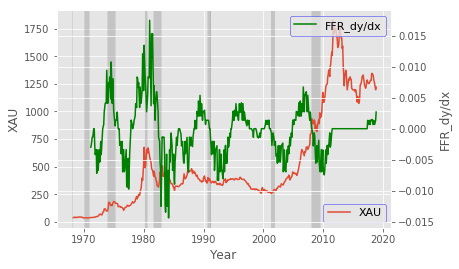

In [47]:
graph_data(df['XAU'], df['FFR_dy/dx'])

This doesn't tell us much more than the FFR does, but it visualizes what values will be used in the algorithm.

The function below is used to create an association table.

In [10]:
def association_table(columns):
    #association before 2008
    df_corr = columns.corr()
    print(df_corr.head())

    data = df_corr.values
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    column_labels = df_corr.columns
    row_labels = df_corr.index

    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap.set_clim(-1,1)
    plt.tight_layout()
    plt.show()

          XAU       CCI       FFR
XAU  1.000000  0.016759 -0.549254
CCI  0.016759  1.000000 -0.308627
FFR -0.549254 -0.308627  1.000000


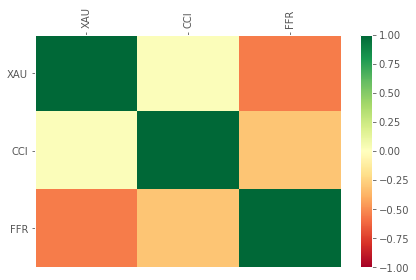

In [11]:
association_table(df[['XAU', 'CCI', 'FFR']])

From this we can see a slightly negative correlation between CCI and FFR. This makes sense since low interest rates encourage economic growth and higher consumer confidence. Since the fed reduced rates to 0 after the 2008 crash, it appears to be negatively correlated with gold. Let's take a look at the association before 2008.

          XAU       CCI       FFR
XAU  1.000000 -0.031665  0.095407
CCI -0.031665  1.000000 -0.403146
FFR  0.095407 -0.403146  1.000000


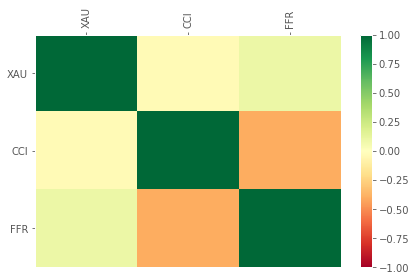

In [12]:
association_table(df[['XAU', 'CCI', 'FFR']][:'2008-01-01'])

This shows the relationship a bit better. Since some indicators lead and others follow, the association with respect to the same index doesn't show much of an association.

Lastly, a function to graph the moving averages of gold is created.

In [13]:
#moving avg crossover 
def moving_avg(a,b,c):
    style.use('ggplot')
    fig, ax1 = plt.subplots()
    ax1.plot(a.index, a)
    ax1.plot(b.index, b)
    ax1.plot(a.index, c)


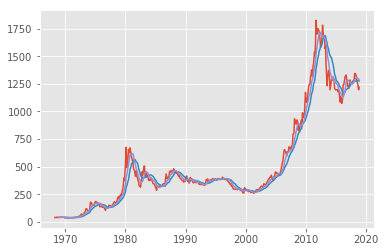

In [14]:
moving_avg(df['XAU'], df['MA14'], df['MA7'])

Since the algorithm will only be trading on data after 2004, it will be better to look at that timeframe.

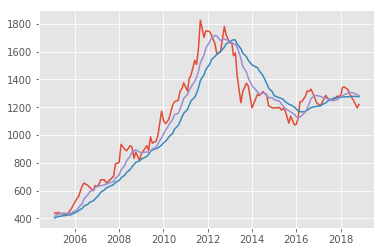

In [15]:
moving_avg(df['XAU']['2005-01-01':], df['MA14']['2005-01-01':], df['MA7']['2005-01-01':])

From this graph, we can see that when the purple line(one week MA) is above the blue(two week MA), we should buy. When the two crossover, we should sell.

With this information, we can move on to creating an algorithm.